# Population Balances for Polymer Systems

This notebook serves as a companion to Lecture #1, providing practical examples and exercises related to the population balance equations for polymer systems.

Real polymerization systems can involve tens or even hundreds of distinct reactions. However, from a formal perspective, most reactions can be viewed as particular cases of a handful of fundamental reaction steps. In this notebook, we will focus on the four most important base steps through which polymer chains grow and/or break: propagation, depropagation, combination, and scission.

In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

## Propagation

The chemical equation for the propagation step is given by:

$$ P(n) + M \xrightarrow{k} P(n+1) $$

Here, $k$ is the propagation rate constant, and we assume it is independent of chain length. The
corresponding population balance equation can be written as:

$$ \frac{\textrm{d}[P_n]}{\textrm{d}t} = k [M] \left([P_{n-1}] - [P_n] \right) $$

where $[P_n]$  represents the concentration of a polymer chain with $n$ monomer units and
$[M]$ is the monomer concentration.

Next, the derivatives of the first three moments, $\lambda_0$, $\lambda_1$, and $\lambda_2$,
are:

\begin{align*}
\dot{\lambda}_0 &= 0 \\
\dot{\lambda}_1 &= k [M] \lambda_0 \\
\dot{\lambda}_2 &= k [M] \left( \lambda_0 + 2 \lambda_1 \right) \\
\end{align*}

These equations indicate:
* The number of chains is conserved (since $\dot{\lambda}_0 = 0 $).
* The total number of monomer units incorporated into chains increases at the same rate that the monomer concentration decreases (i.e., $\dot{\lambda}_1 = -\frac{\textrm{d}[M]}{\textrm{d}t} $).

### Numerical Solution

In this section, we will solve the derived equations numerically and generate plots to visualize the evolution of chain length, monomer concentration, and other relevant quantities over time.

First of all, let's define a function to evaluate $\textrm{d}[P_n]/\textrm{d}t$ for the propagation step.

In [2]:
def propagation(P: np.ndarray, M: float,  k: float) -> np.ndarray:
    """P(n) + M --> P(n+1) , k

    d[Pn]/dt = k*[M]*([Pn-1] - [Pn])
    """
    Pdot = k*M*(np.roll(P, 1) - P)
    Pdot[0] = -k*M*P[0]
    return Pdot

Next, we'll define two helper functions. The first will compute the $m$-th moment of a distribution.

In [3]:
def moment(P: np.ndarray, m: int):
    """m-th moment of `P`.

    Parameters
    ----------
    P : np.ndarray
        Distribution.
    m : int
        Order of moment.

    Returns
    -------
    float | np.ndarray
        Moment of distribution `P`.
    """
    s = np.arange(0, P.shape[0])
    return np.dot(s**m, P)

The second helper function will integrate the population balances and plot both the full distribution and its leading moments.

In [4]:
def solve_pbe(Pdot: Callable,
              P0: np.ndarray,
              tend: float
              ) -> tuple[np.ndarray, np.ndarray]:
    """Solve PBE and plot results.

    Parameters
    ----------
    Pdot : Callable
        Derivative of distribution.
    P0 : np.ndarray
        Initial distribution.
    tend : float
        End time.
    
    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Time and distribution.
    """

    # Solve ODE
    teval = np.linspace(0., tend, num=100+1)
    solution = solve_ivp(Pdot,
                         t_span=(0, tend),
                         y0=P0,
                         t_eval=teval,
                         method='RK45',
                         rtol=1e-6)

    t = solution.t
    P = solution.y

    # Plot Number Distribution
    _, ax = plt.subplots()
    s = np.arange(0, P0.size)
    for i in range(0, t.size, round((t.size-1)/10)):
        ax.plot(s, P[:, i], label=f"t={t[i]:.2g}")
    ax.legend(loc="best")
    ax.set_xlabel("Chain length")
    ax.set_ylabel("Number of chains")

    # Moments
    orders = [0, 1, 2]
    _, ax = plt.subplots(len(orders), sharex=True)
    for i, order in enumerate(orders):
        m = moment(P, order)
        ax[i].plot(t, m, label='numerical')
        ax[i].set_ylabel(rf"$\lambda_{i}$")
    ax[-1].set_xlabel("Time")

    return t, P

Ok, we're ready for the final step. We just need to define an initial distribution and call `solve_pbe()`.

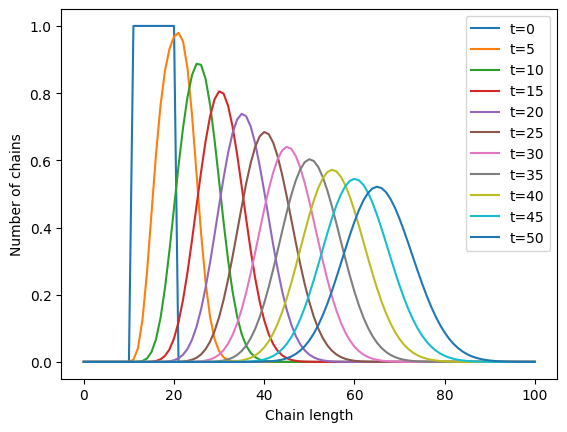

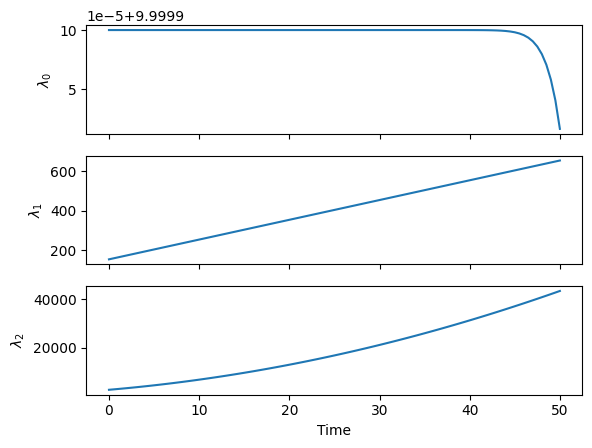

In [5]:
# Initial distribution
nmax = 100
i0 = 10
iwidth = 10
P0 = np.zeros(nmax+1)
P0[i0+1:i0+1+iwidth] = 1.

_ = solve_pbe(lambda t, P: propagation(P, M=1.0, k=1.0),
              P0=P0,
              tend=50.
              )

As expected, as time evolves, the distribution shifts to the right, the number of chains ($\lambda_0$) remains constant, and the other moments increase.

However, a closer look at the distribution reveals something unexpected. We began with a "rectangular" distribution and assumed that all chains grow at the same rate, regardless of their length. Surprisingly, it turns out that some chains grew faster or slower than the average. Why is this?

This phenomenon is called _stochastic broadening_, and as the name suggests, it has a statistical origin. The monomer has no preference for any specific chain and will, on average, add the same number of times to each macromolecule. However, due to natural statistical variation, some chains will experience more or fewer addition events than the average.


### Questions

* What happens if we double `tend`? Why?
* What happens if we simulate "backwards", i.e. with a negative $k$ or end time?
* Derive an expression for the time derivative of the polydispersity index.

## Depropagation

The chemical equation for the depropagation step is given by:

$$ P(n) \xrightarrow{k} P(n-1) + M $$

Here, $k$ is the depropagation rate constant, and we assume it is independent of chain length.
The corresponding population balance equation can be written as:

\begin{align*}
\frac{\textrm{d}[P_1]}{\textrm{d}t} & = k [P_{2}] \\
\frac{\textrm{d}[P_n]}{\textrm{d}t} & = k \left([P_{n+1}] - [P_n] \right), n \ge 2
\end{align*}

where $[P_n]$ represents the concentration of a polymer chain with $n$ monomer units, and
$[M]$ is the monomer concentration.

Next, the derivatives of the first three moments are:

\begin{align*}
\dot{\lambda}_0 &= 0 \\
\dot{\lambda}_1 & \approx - k \lambda_0 \\
\dot{\lambda}_2 & \approx k \left( \lambda_0 - 2 \lambda_1 \right) \\
\end{align*}

These equations indicate:
* The number of chains is conserved (since $\dot{\lambda}_0 = 0 $).
* The total number of monomer units incorporated into chains decreases at the same rate that the monomer concentration increases (i.e., $\dot{\lambda}_1 = -\frac{\textrm{d}[M]}{\textrm{d}t} $).

### Numerical Solution

Following what we did above for propagation, let's define a function to evaluate $\textrm{d}[P_n]/\textrm{d}t$ for the depropagation step.

In [6]:
def depropagation(P: np.ndarray, k: float) -> np.ndarray:
    """P(n) -> P(n-1) + M , k
    
    d[Pn]/dt = k*([Pn+1] - [Pn]), n>1
    d[P1]/dt = k*[P2]
    """
    Pdot = k*(np.roll(P, -1) - P)
    Pdot[-1] = -k*P[-1]
    Pdot[1] = k*P[2]
    Pdot[0] = 0.0
    return Pdot

And now we solve it with a suitable initial distribution.

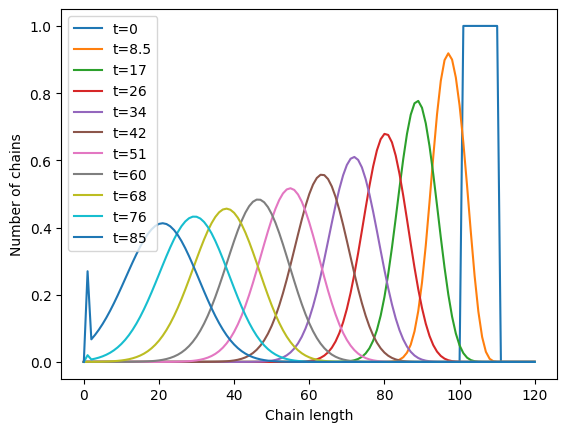

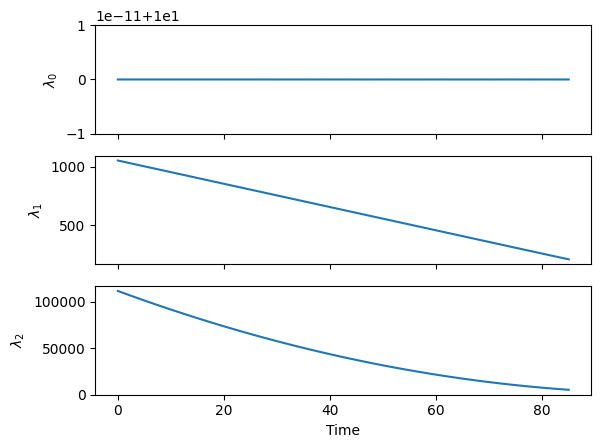

In [7]:
# Initial distribution
nmax = 120
i0 = 100
iwidth = 10
P0 = np.zeros(nmax+1)
P0[i0+1:i0+1+iwidth] = 1.

_ = solve_pbe(lambda t, P: depropagation(P, k=1.0),
              P0=P0,
              tend=85.
              )

As expected, depropagation is almost like the reverse of propagation, with one subtle difference: chains cannot become smaller than a single monomer unit. As a result, at sufficiently long times, the distributions gets smashed against the $n=1$ boundary.

### Questions

* Compare the population balance equations for propagation and depropagation. Why is depropagation not just the time reverse of propagation (ignore the factor $k [M]$)?
* What is the relationship between the _difference_ equations for (de)propagation and the following hyperbolic partial _differential_ equation?
    $$ \frac{\partial P}{\partial t} =- a\frac{\partial P}{\partial n} + b\frac{\partial^2 P}{\partial n^2} $$


## Combination

The chemical equation for the combination step is given by:

$$ P(n) + P(m) \xrightarrow{k} P(n+m) $$

Here, $k$ is the combination rate constant, and we assume it is independent of chain length. The
corresponding population balance equation can be written as:

$$
\frac{\textrm{d}[P_n]}{\textrm{d}t} = \tfrac{1}{2} k \sum_{j=1}^{n-1} [P_{j}] [P_{n-j}] - k [P_n] \sum_{j=1}^{\infty} [P_{j}] 
$$

where $[P_n]$ represents the concentration of a polymer chain with $n$ monomer units. The first
summation on the right-hand side is a particular case of a [discrete convolution](https://en.wikipedia.org/wiki/Convolution).

Next, the derivatives of the first three moments are:

\begin{align*}
\dot{\lambda}_0 &= - \frac{1}{2} k \lambda_0 \\
\dot{\lambda}_1 &= 0 \\
\dot{\lambda}_2 &= k \lambda_1^2
\end{align*}

These equations indicate:
* The number of chains decreases, since one chain is lost per combination event.
* The total number of monomer units incorporated into chains remains constant, since mass is conserved during combination.

### Numerical Solution

Following the same approach as for the other reaction steps, let's define a function to evaluate $\textrm{d}[P_n]/\textrm{d}t$ for the combination step.

In [8]:
def combination(P: np.ndarray, k: float) -> np.ndarray:
    """P(n) + P(m) -> P(n+m) , k

    d[Pn]/dt = 0.5*k * sum j=1:n-1 [Pn-j]*[Pj] - k*[Pn]*sum([Pj])
    """
    Pplus = 0.5 * np.convolve(P, P, mode='full')[:P.size]
    Pminus = P*P.sum()
    Pdot = k*(Pplus - Pminus)
    return Pdot

Now, let's solve it with a suitable initial distribution. Choosing a narrow initial distribution helps make the effects of combination more visible.

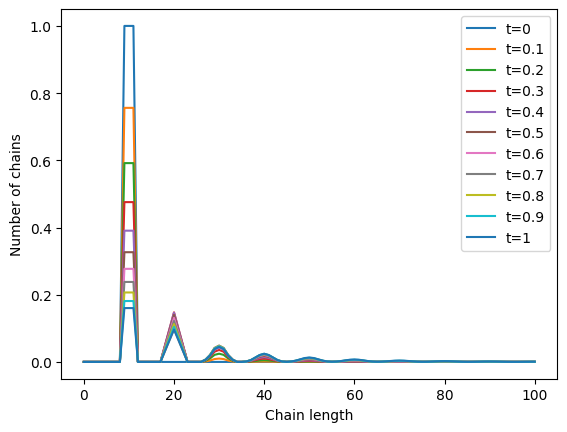

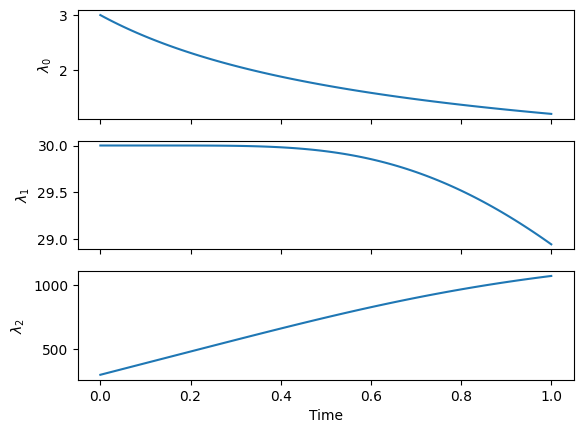

In [9]:
# Initial distribution
nmax = 100
i0 = 8
iwidth = 3
P0 = np.zeros(nmax+1)
P0[i0+1:i0+1+iwidth] = 1.

_ = solve_pbe(lambda t, P: combination(P, k=1.0),
              P0=P0,
              tend=1.
              )

Notice how new chains are formed at integer multiples of the initial mean chain length. Also, observe the small loss of total mass, which occurs because long chains are quickly formed and escape the numerical domain (you can fix it by increasing `nmax`).

### Questions

* How would you describe the numerical complexity of the combination step compared to (de)propagation? Is it simpler or more complex? Why?
* Name two types of concrete polymerization reactions that are particular forms of the combination step.

## Random Scission

The chemical equation for the random scission step is given by:

$$ P(n + m) \xrightarrow{k} P(n) + P(m) $$

Here, $k$ is the scission rate constant, and we assume it is independent of chain length. The
corresponding population balance equation can be written as:

$$
\frac{\textrm{d}[P_n]}{\textrm{d}t} = 2 k \sum_{j=n+1}^{\infty} [P_{j}]  - k (n - 1) [P_n] 
$$

where $[P_n]$  represents the concentration of a polymer chain with $n$ monomer units. The
summation on the right-hand side is a particular case of a [cumulative sum](https://mathworld.wolfram.com/CumulativeSum.html).

Next, the derivatives of the first three moments are:

\begin{align*}
\dot{\lambda}_0 &= k (\lambda_1 - \lambda_0) \\
\dot{\lambda}_1 &= 0 \\
\dot{\lambda}_2 &=  k (\lambda_1 - \lambda_3)/3
\end{align*}

These equations indicate:
* The number of chains increases, since $\lambda_1 \ge \lambda_0$ (the equality is only reached if/when all chains have unit length).
* The total number of monomer units incorporated into chains remains constant, since mass is conserved during cleavage.
* The moment equations do not form a closed set, since $\lambda_2$ depends on $\lambda_3$ and so forth.

### Numerical Solution

Following the same approach as for the other reaction steps, let's define a function to evaluate $\textrm{d}[P_n]/\textrm{d}t$ for the random scission step.

In [10]:
def scission(P: np.ndarray, k: float) -> np.ndarray:
    "P(n) -> P(n-m) + P(m) , k"
    # Source term
    Pplus = np.zeros_like(P)
    Pplus[1:-1] = 2* np.cumsum(P[2:][::-1])[::-1]
    # Sink term
    s = np.arange(0, P.size)
    Pminus = (s - 1)*P
    Pminus[0] = 0.
    Pdot = k*(Pplus - Pminus)
    return Pdot

Now, let's solve it using a suitable initial distribution, such as the one we used for the depropagation step.

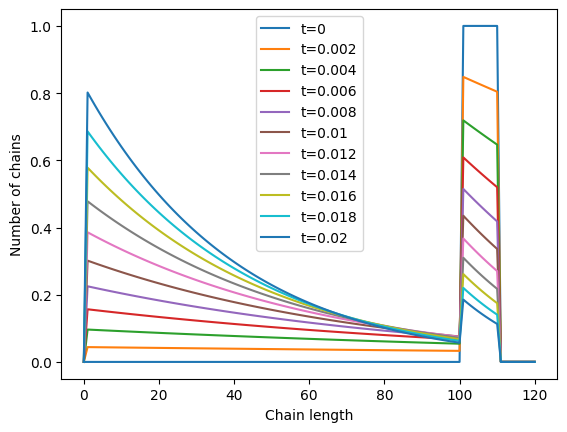

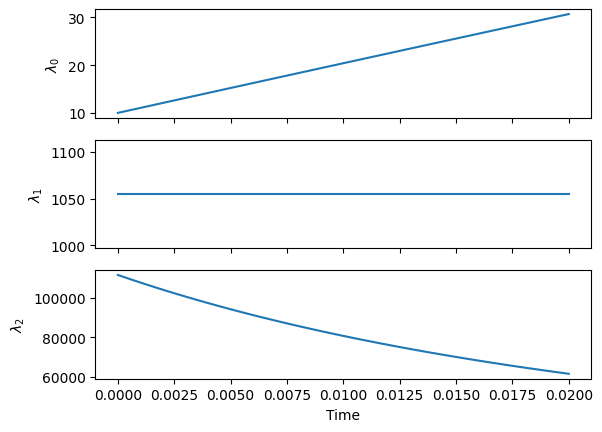

In [11]:
# Initial distribution
nmax = 120
i0 = 100
iwidth = 10
P0 = np.zeros(nmax+1)
P0[i0+1:i0+1+iwidth] = 1.

_ = solve_pbe(lambda t, P: scission(P, k=1.0),
              P0=P0,
              tend=0.02
              )

Since scission is assumed to occur randomly along the chain, the distribution of the new chains is initially uniform (the portion of the orange curve between 0 and 100 is flat). As scission progresses, the relative fraction of shorter chains increases, and the distribution increasingly resembles a (truncated) [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution).